# 📊 Overview of Dataset

This dataset contains **13751 images of mammals** 🐾.
The collection is designed for image classification tasks.

You can use this dataset to **recognize different types of mammals from photos**.

The pictures are divided into **45 classes**.

⚠️ Note: The photos have a resolution of **256x256 pixels**, providing a consistent size for analysis.

# ⬇️ Install packages and import necessary library
This cell installs essential dependencies for the project and load all core libraries required for data processing, visualization,
and model development


In [46]:
# ========================================================
# 🧩 Import basic libraries
# ========================================================
import os
import glob
import random
import zipfile
import gc
import numpy as np
from collections import Counter

# ========================================================
# 🧠 For image and video processing (OpenCV)
# ========================================================
!pip install opencv-python
import cv2
from PIL import Image

# ========================================================
# 📁 For downloading datasets directly from Kaggle
# ========================================================
!pip install kagglehub
import kagglehub

# ========================================================
# 📊 For data visualization and plotting
# ========================================================
!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================================
# 🧮 For machine learning utilities
# ========================================================
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern, hog
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


# ========================================================
# 🧰 For type hints and annotations
# ========================================================
from typing import Tuple, List, Optional, Literal, Dict

# ========================================================
# 🕒 For computing time
# ========================================================
import time

# ========================================================
# 📁 For pytorch models
# ========================================================
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models




print("✅ All packages installed and imported successfully!")


✅ All packages installed and imported successfully!


# 📥 Download Dataset
This section downloads the Mammals Image Classification Dataset directly from Kaggle using the kagglehub library.
- Step 1: Retrieve the latest version of the dataset automatically from Kaggle.
- Step 2: Define and set up the dataset directory path for later use.



In [47]:
# Download latest version
path = kagglehub.dataset_download("asaniczka/mammals-image-classification-dataset-45-animals")

# ------------------------------------------------
# Setup dataset path
# ------------------------------------------------

DATASET_DIR = os.path.join(path, "mammals")

print("="*60)
print("MAMMALS DATASET INFORMATION")
print("="*60)
print(f"📁 Dataset Path: {DATASET_DIR}")

MAMMALS DATASET INFORMATION
📁 Dataset Path: /root/.cache/kagglehub/datasets/asaniczka/mammals-image-classification-dataset-45-animals/versions/1/mammals


# 🗂️ Organize and Store Images and Labels
This section collects all image file paths from the downloaded dataset into a structured list or DataFrame.
It helps you easily manage, shuffle, and split data later for training, validation, and testing

In [48]:
# Initialize lists to store image paths and labels
images_path = []
labels = []

# ---------------------------------------------------------------------------
# Loop through each class folder and collect image file paths
# ---------------------------------------------------------------------------


for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            images_path.append(img_path)
            labels.append(class_name)


print("="*60)
print("📋 IMAGE PATHS SUMMARY")
print("="*60)
print(f"🖼️ Total Images Collected: {len(images_path)}")
print(f"🔢 Total Classes: {len(set(labels))}")


📋 IMAGE PATHS SUMMARY
🖼️ Total Images Collected: 13751
🔢 Total Classes: 45


# 1.📊EDA (Exploratory Data Analysis)

## 1.1 🔍 Counting and Analyzing Dataset Images

This section counts how many images exist in each class folder within the dataset.\
It then calculates key statistics to help understand dataset balance and distribution:

- **Total Images:** The total number of images across all classes.
- **Average per Class:** The mean number of images per category.
- **Minimum & Maximum:** The classes with the fewest and most images.

This analysis provides a quick insight into **dataset balance**, which is crucial for building fair and effective classification models.

In [49]:
# ------------------------------------------------
# Counting images in each class
# ------------------------------------------------

class_counts = Counter(labels)

# Calculate statistics
total_images = len(images_path)
num_classes = len(class_counts)
avg_images = total_images / num_classes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"📊 Total Images: {total_images:,}")
print(f"📈 Average Images per Class: {avg_images:.1f}")
print(f"📉 Minimum: {class_counts[min_class]} images ({min_class})")
print(f"📈 Maximum: {class_counts[max_class]} images ({max_class})")



DATASET STATISTICS
📊 Total Images: 13,751
📈 Average Images per Class: 305.6
📉 Minimum: 215 images (vicuna)
📈 Maximum: 356 images (polar_bear)


## 1.2 📈 Visualizing Dataset Distribution and Sample Images  

This section provides a visual overview of the dataset to better understand its structure and diversity.  

## 1️⃣ Plot Class Distribution  
A bar chart is created to show how images are distributed across different mammal classes.  
This helps identify any **class imbalance** that could affect model performance.  
Each bar represents one class, with the number of images labeled above it.  

## 2️⃣ Display Sample Images  
Randomly selected images from a few classes are displayed to give a quick visual inspection of the dataset quality and variety.  
This helps verify that the dataset was **downloaded and organized correctly**, and provides insight into the **visual differences between classes**.  


In [50]:
# ----------------------------------------------------------
# Plot distribution
# ----------------------------------------------------------

plt.figure(figsize=(16, 8))
bars = plt.bar(class_counts.keys(), class_counts.values(), color="skyblue", edgecolor="black")

plt.title("Class Distribution of Mammals Dataset", fontsize=14, weight="bold")
plt.xlabel("Mammal Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.xticks(rotation=90, ha="right", fontsize=8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height),
             ha="center", va="bottom", fontsize=7, weight="bold")

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# Sample Visualization
# ------------------------------------------------------

# Get the list of all class names
all_classes = list(class_counts.keys())
classes_with_idx = {class_name: [idx for idx, label in enumerate(labels) if label == class_name] for class_name in all_classes}
for class_name in random.sample(all_classes, 5):
    indicies_of_class = classes_with_idx[class_name]

    sample_images = random.sample(indicies_of_class, 3)
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    for i, img_idx in enumerate(sample_images):
        img = cv2.imread(images_path[img_idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(class_name.replace('_', ' ').title())
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 1.3 ⚠️ Detect Missing or Corrupted Images

Identify unreadable or broken image files (e.g., empty, unreadable, or size = 0).

In [51]:
# ----------------------------------------------------------
# Check broken image
# ----------------------------------------------------------


broken = [p for p in images_path if not os.path.exists(p) or os.path.getsize(p) == 0]

print(f"Possible broken images: {len(broken)}")




Possible broken images: 0


## 1.4 💡 Analyze Brightness Distribution Trends
Compute and visualize the average brightness (intensity) of images to understand exposure and lighting trends.


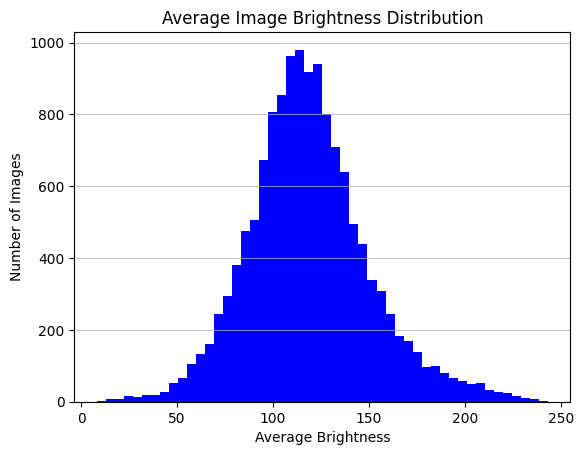

In [52]:
brightness = []

for cls, indices in classes_with_idx.items():
    for idx in indices:
        path = images_path[idx]

        # Read image
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Skipping broken image: {path}")
            continue

        # Compute average brightness (RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        brightness.append(np.mean(img))

        del img

    # Clean garbage
    gc.collect()

# Plot histogram
plt.hist(brightness, bins=50, color='blue')
plt.title("Average Image Brightness Distribution")
plt.xlabel("Average Brightness")
plt.ylabel("Number of Images")
plt.grid(axis='y', alpha=0.75)
plt.show()

# 2.🧹Data Preprocessing

This module defines a clean and modular way to **load, transform, split, and prepare image datasets** for PyTorch models.

## 2.1 📦 `ImageDataset` Class

A custom PyTorch `Dataset` for lazy-loading images from file paths, applying transformations, and handling corrupted or missing files gracefully.


    ✅ Key Features

✅ Lazy image loading (only loads when accessed)

⚙️ Handles broken/missing files safely

🧩 Compatible with torchvision.transforms

🧠 Returns (image_tensor, label) pairs

In [53]:

class ImageDataset(Dataset):

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        # Load image only when requested

        img_path = self.image_paths[idx]

        label = self.labels[idx]

        try:
            img = cv2.imread(img_path)
            if img is None:
                # Return black image if load fails
                img = np.zeros((224,224,3), dtype=np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image before applying transforms
            img = Image.fromarray(img)

            # Apply transforms
            if self.transform:
                img = self.transform(img)

            return img, label

        except Exception as e:
            # Return black image on error
            img = torch.zeros((3, 224,224), dtype=torch.float32)
            return img, label



## 2.2 ⚙️ `DataProcessor` Class

This class orchestrates the data processing pipeline, from splitting the data to creating PyTorch DataLoaders.

**Key Responsibilities:**

- **Initialization**: Sets up configuration like image size, split ratios, batch size, and the number of workers.
- **Label Encoding**: Converts string labels into numerical format using `LabelEncoder`.
- **Data Splitting**: Divides the dataset into training, validation, and testing sets using `train_test_split` with stratification to maintain class distribution.
- **Dataset Creation**: Instantiates the `ImageDataset` for each split, applying specified transformations.
- **DataLoader Creation**: Generates PyTorch `DataLoader` objects for efficient batching and loading of data during model training and evaluation.
- **Access Methods**: Provides methods to retrieve the created datasets, DataLoaders, and the encoded class names.

In [54]:

class DataProcessor:


    def __init__(
        self,
        img_size: Tuple[int, int] = (224, 224),
        test_size: float = 0.2,
        val_size: float = 0.25,
        random_state: int = 42,
        batch_size: int = 32,
        num_workers: int = 4,
        transform = None,
        verbose: bool = True,
    ):
        self.img_size = img_size
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.verbose = verbose
        self.transform = transform

        self.label_encoder = LabelEncoder()

        # Store datasets for later use
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

        if self.verbose:
            print("="*60)
            print("🖥️  DATA PROCESSOR")
            print("="*60)
            print(f"🖼️  Image size: {self.img_size}")
            print(f"🔄 Batch size: {self.batch_size}")
            print(f"👷 Workers: {self.num_workers}\n")

    def prepare(self, images_path: List[str], labels: List):

        if self.verbose:
            print("📊 Total images:", len(images_path))


        if self.verbose:
            print("\n🏷️  Encoding labels...")
        labels_encoded = self.label_encoder.fit_transform(labels)
        if self.verbose:
            print(f"✓ Classes: {list(self.label_encoder.classes_)}")


        if self.verbose:
            print("\n✂️  Splitting dataset...")

        indices = np.arange(len(images_path))
        idx_temp, idx_test = train_test_split(
            indices,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=labels_encoded
        )

        idx_train, idx_val = train_test_split(
            idx_temp,
            test_size=self.val_size,
            random_state=self.random_state,
            stratify=labels_encoded[idx_temp]
        )

        if self.verbose:
            total = len(idx_train) + len(idx_val) + len(idx_test)
            print(f"✓ Train: {len(idx_train)} ({len(idx_train)/total*100:.1f}%)")
            print(f"✓ Val:   {len(idx_val)} ({len(idx_val)/total*100:.1f}%)")
            print(f"✓ Test:  {len(idx_test)} ({len(idx_test)/total*100:.1f}%)")

        if self.verbose:
            print("\n📦 Creating datasets...")

        train_dataset_temp = ImageDataset(
            [images_path[i] for i in idx_train],
            labels_encoded[idx_train],
            transform=self.transform
        )


        self.train_dataset = ImageDataset(
            [images_path[i] for i in idx_train],
            labels_encoded[idx_train],
            transform=self.transform
        )

        self.val_dataset = ImageDataset(
            [images_path[i] for i in idx_val],
            labels_encoded[idx_val],
            transform=self.transform
        )

        self.test_dataset = ImageDataset(
            [images_path[i] for i in idx_test],
            labels_encoded[idx_test],
            transform=self.transform
        )

        if self.verbose:
            print("\n🔄 Creating DataLoaders...")

        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            prefetch_factor=2 if self.num_workers > 0 else None
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            prefetch_factor=2 if self.num_workers > 0 else None
        )

        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            prefetch_factor=2 if self.num_workers > 0 else None
        )

        if self.verbose:
            print("✓ DataLoaders created")
            print(f"  Train: {len(self.train_dataset)} samples, {len(self.train_loader)} batches")
            print(f"  Val:   {len(self.val_dataset)} samples, {len(self.val_loader)} batches")
            print(f"  Test:  {len(self.test_dataset)} samples, {len(self.test_loader)} batches")
            print("\n" + "="*60)
            print("✅ DATA PROCESSING COMPLETED")
            print("="*60 + "\n")

    def get_dataloaders(self):

        return self.train_loader, self.val_loader, self.test_loader

    def get_datasets(self):

        return self.train_dataset, self.val_dataset, self.test_dataset

    def get_class_names(self):

        return self.label_encoder.classes_


# 3.🧠 Feature Extraction

## 3.1 🎚️ Feature Extractor Class

  The FeatureExtractor class provides a unified interface for extracting features from images using either traditional computer vision methods (HOG) or deep learning pretrained models (ResNet, VGG, EfficientNet).

In [55]:
class FeatureExtractor:
    def __init__(
            self,
            method: Literal['hog', 'resnet', 'vgg', 'efficientnet'],
            device='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=True
    ):
        self.method = method
        self.device = device
        self.verbose = verbose
        self.model = None

        if method in ['resnet', 'vgg', 'efficientnet']:
            self._load_model()

        if self.verbose:
            print("=" * 60)
            print("🔬 FEATURE EXTRACTOR")
            print("=" * 60)
            print(f"📌 Method: {method.upper()}")
            print(f"💻 Device: {device}")


        if self.verbose:
            print("=" * 60 + "\n")

    def _load_model(self):
        """Load pretrained deep learning models"""
        if self.verbose:
            print(f"🔧 Loading pretrained {self.method.upper()}...")

        if self.method == 'resnet':
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.model = nn.Sequential(*list(self.model.children())[:-1])

        elif self.method == 'vgg':
            self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            self.model = nn.Sequential(
                self.model.features,
                nn.AdaptiveAvgPool2d((1,1))
            )

        elif self.method == 'efficientnet':
            self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
            self.model = nn.Sequential(*list(self.model.children())[:-1])

        self.model.to(self.device)
        self.model.eval()

        if self.verbose:
            print(f"✓ Model loaded successfully")

    def _extract_hog(self, image):
        """Extract HOG features"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image

        gray = cv2.resize(gray, (128, 128))
        hog_descriptor = cv2.HOGDescriptor(
            _winSize=(128, 128),
            _blockSize=(24,24),
            _blockStride=(8,8),
            _cellSize=(8,8),
            _nbins= 9
        )
        return hog_descriptor.compute(gray).flatten()

    def _extract_from_loader(self, dataloader, split_name=""):

        features_list = []
        labels_list = []

        if self.verbose:
            print(f"🔍 Extracting {self.method.upper()} features from {split_name}...")

        total_batches = len(dataloader)

        if self.method =='hog':
            # Traditional methods
            processed = 0
            total = len(dataloader.dataset)

            for batch_imgs, batch_labels in dataloader:
                batch_features = []

                for img_tensor in batch_imgs:
                    # Convert tensor to numpy
                    img = img_tensor.permute(1, 2, 0).numpy()
                    img = (img * 255).astype(np.uint8)

                    # Extract features
                    features = self._extract_hog(img)

                    batch_features.append(features)

                features_list.extend(batch_features)
                labels_list.extend(batch_labels.numpy())

                processed += len(batch_imgs)
                if self.verbose and (processed % 500 == 0 or processed == total):
                    print(f"  Processed {processed}/{total} images")

        else:
            # Deep learning methods
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(dataloader):
                    images = images.to(self.device)

                    features = self.model(images)
                    features = features.view(features.size(0), -1)

                    features_list.append(features.cpu().numpy())
                    labels_list.append(labels.numpy())

                    if self.verbose and ((batch_idx + 1) % 20 == 0 or (batch_idx + 1) == total_batches):
                        print(f"  Batch {batch_idx + 1}/{total_batches}")

        if self.method == 'hog':
            features = np.vstack(features_list)
            labels = np.array(labels_list)
        else:
            features = np.vstack(features_list)
            labels = np.concatenate(labels_list)

        return features, labels

    def extract(self, train_loader, val_loader, test_loader):

        X_train, y_train = self._extract_from_loader(train_loader, "train set")

        X_val, y_val = self._extract_from_loader(val_loader, "validation set")

        X_test, y_test = self._extract_from_loader(test_loader, "test set")

        if self.verbose:
            print("=" * 60)
            print("✅ FEATURE EXTRACTION COMPLETED")
            print("=" * 60)
            print(f"📊 Feature shapes:")
            print(f"   Train: {X_train.shape}")
            print(f"   Val:   {X_val.shape}")
            print(f"   Test:  {X_test.shape}")
            print("=" * 60 + "\n")

        return X_train, X_val, X_test, y_train, y_val, y_test

## 3.2 🔻📊 PCA Reducer Class

In [56]:
class PCAReducer:
    def __init__(self, n_components=None, variance_ratio=0.95, verbose=True):

        self.n_components = n_components
        self.variance_ratio = variance_ratio
        self.verbose = verbose
        self.pca = None
        self.original_dim = None
        self.reduced_dim = None

    def fit_transform(self, X_train, X_val=None, X_test=None):

        self.original_dim = X_train.shape[1]

        if self.verbose:
            print("=" * 60)
            print("📉 PCA DIMENSIONALITY REDUCTION")
            print("=" * 60)
            print(f"📊 Original dimension: {self.original_dim}")

        # Fit PCA
        if self.n_components is None:
            # Automatically select dim
            if self.verbose:
                print(f"🎯 Target variance ratio: {self.variance_ratio:.2%}")
                print("🔍 Finding optimal number of components...")

            self.pca = PCA(n_components=self.variance_ratio)
            X_train_reduced = self.pca.fit_transform(X_train)
            self.reduced_dim = self.pca.n_components_

        else:
            # Use specific dimension
            if self.verbose:
                print(f"🎯 Target components: {self.n_components}")

            self.pca = PCA(n_components=self.n_components)
            X_train_reduced = self.pca.fit_transform(X_train)
            self.reduced_dim = self.n_components

        # Transform validation and test sets
        X_val_reduced = self.pca.transform(X_val) if X_val is not None else None
        X_test_reduced = self.pca.transform(X_test) if X_test is not None else None

        if self.verbose:
            print(f"✓ Reduced dimension: {self.reduced_dim}")
            print(f"✓ Variance explained: {self.pca.explained_variance_ratio_.sum():.2%}")
            print(f"✓ Dimension reduction: {self.original_dim} → {self.reduced_dim}")
            print(f"✓ Compression ratio: {self.reduced_dim / self.original_dim:.2%}")
            print("=" * 60 + "\n")

        return X_train_reduced, X_val_reduced, X_test_reduced


# 4.🏋️‍♂️🤖 Training Class

In [57]:
class ModelTrainer:
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.models = {}
        self.results = {}

    def prepare_models(self):
        if self.verbose:
            print("=" * 60)
            print("🤖 INITIALIZING MODELS")
            print("=" * 60)

        self.models = {
            'SVM': SVC(kernel='linear', C=0.7, gamma='scale', random_state=42),
            'Random Forest': RandomForestClassifier(
                n_estimators=200,
                max_depth=25,
                min_samples_split=5,
                max_features='sqrt',
                random_state=42,
                n_jobs=-1
            ),
            'Logistic Regression': LogisticRegression(
                max_iter=1000,
                random_state=42,
                n_jobs=-1
            )
        }

        if self.verbose:
            for name in self.models.keys():
                print(f"✓ {name}")
            print("=" * 60 + "\n")

    def train_and_evaluate(
            self,
            X_train, X_val, X_test,
            y_train, y_val, y_test,
            feature_name: str
    ) -> Dict:

        if self.verbose:
            print("=" * 60)
            print(f"🎯 TRAINING WITH {feature_name.upper()} FEATURES")
            print("=" * 60)

        results = {}

        for model_name, model in self.models.items():
            if self.verbose:
                print(f"\n🔧 Training {model_name}...")

            start_time = time.time()

            # Train
            model.fit(X_train, y_train)
            train_time = time.time() - start_time

            # Predict
            start_time = time.time()
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
            inference_time = (time.time() - start_time) / len(X_test)

            # Calculate metrics
            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)
            test_acc = accuracy_score(y_test, test_pred)

            precision, recall, f1, _ = precision_recall_fscore_support(
                y_test, test_pred, average='weighted', zero_division=0
            )

            cm = confusion_matrix(y_test, test_pred)

            results[model_name] = {
                'train_accuracy': train_acc,
                'val_accuracy': val_acc,
                'test_accuracy': test_acc,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'confusion_matrix': cm,
                'train_time': train_time,
                'inference_time': inference_time,
                'predictions': test_pred
            }

            if self.verbose:
                print(f"  ✓ Train Acc: {train_acc:.4f}")
                print(f"  ✓ Val Acc:   {val_acc:.4f}")
                print(f"  ✓ Test Acc:  {test_acc:.4f}")
                print(f"  ✓ F1 Score:  {f1:.4f}")
                print(f"  ⏱ Train Time: {train_time:.2f}s")

        if self.verbose:
            print("=" * 60 + "\n")

        return results

# 5.🏆📈 Model Comparator

In [58]:
class ModelComparator:
    def __init__(self):
        self.all_results = {}

    def add_results(self, feature_name: str, results: Dict):
        """Add results from a feature extraction method"""
        self.all_results[feature_name] = results

    def print_comparison(self):
        """Print comparison table of all methods"""
        print("\n" + "=" * 100)
        print("📊 COMPREHENSIVE MODEL COMPARISON")
        print("=" * 100)

        # Header
        header = f"{'Feature Method':<20} {'Model':<20} {'Test Acc':<12} {'F1 Score':<12} {'Train Time':<12} {'Inf Time (ms)':<15}"
        print(header)
        print("-" * 100)

        # Results
        for feature_name, models_results in self.all_results.items():
            for model_name, metrics in models_results.items():
                row = (
                    f"{feature_name:<20} "
                    f"{model_name:<20} "
                    f"{metrics['test_accuracy']:<12.4f} "
                    f"{metrics['f1_score']:<12.4f} "
                    f"{metrics['train_time']:<12.2f} "
                    f"{metrics['inference_time'] * 1000:<15.4f}"
                )
                print(row)
            print("-" * 100)

        print("\n")

    def find_best_model(self) -> Tuple[str, str, float]:
        """Find the best performing model overall"""
        best_acc = 0
        best_feature = ""
        best_model = ""

        for feature_name, models_results in self.all_results.items():
            for model_name, metrics in models_results.items():
                if metrics['test_accuracy'] > best_acc:
                    best_acc = metrics['test_accuracy']
                    best_feature = feature_name
                    best_model = model_name

        print("=" * 100)
        print("🏆 BEST MODEL")
        print("=" * 100)
        print(f"Feature Method: {best_feature}")
        print(f"Model: {best_model}")
        print(f"Test Accuracy: {best_acc:.4f}")
        print("=" * 100 + "\n")

        return best_feature, best_model, best_acc

    def plot_comparison(self, save_path=None):
        """Create visualization comparing all methods"""
        # Prepare data for plotting
        feature_methods = []
        model_names = []
        accuracies = []
        f1_scores = []

        for feature_name, models_results in self.all_results.items():
            for model_name, metrics in models_results.items():
                feature_methods.append(feature_name)
                model_names.append(model_name)
                accuracies.append(metrics['test_accuracy'])
                f1_scores.append(metrics['f1_score'])

        # Create combined labels
        labels = [f"{f}\n{m}" for f, m in zip(feature_methods, model_names)]

        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

        # 1. Accuracy comparison
        ax1 = axes[0, 0]
        colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))
        bars1 = ax1.bar(range(len(accuracies)), accuracies, color=colors)
        ax1.set_xlabel('Feature Method + Model')
        ax1.set_ylabel('Test Accuracy')
        ax1.set_title('Test Accuracy Comparison')
        ax1.set_xticks(range(len(labels)))
        ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
        ax1.set_ylim([0, 1])
        ax1.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

        # 2. F1 Score comparison
        ax2 = axes[0, 1]
        bars2 = ax2.bar(range(len(f1_scores)), f1_scores, color=colors)
        ax2.set_xlabel('Feature Method + Model')
        ax2.set_ylabel('F1 Score')
        ax2.set_title('F1 Score Comparison')
        ax2.set_xticks(range(len(labels)))
        ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
        ax2.set_ylim([0, 1])
        ax2.grid(axis='y', alpha=0.3)

        for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
            ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     f'{f1:.3f}', ha='center', va='bottom', fontsize=8)

        # 3. Training time comparison
        ax3 = axes[1, 0]
        train_times = [self.all_results[f][m]['train_time']
                       for f, m in zip(feature_methods, model_names)]
        bars3 = ax3.bar(range(len(train_times)), train_times, color=colors)
        ax3.set_xlabel('Feature Method + Model')
        ax3.set_ylabel('Training Time (seconds)')
        ax3.set_title('Training Time Comparison')
        ax3.set_xticks(range(len(labels)))
        ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
        ax3.grid(axis='y', alpha=0.3)

        # 4. Grouped comparison by feature method
        ax4 = axes[1, 1]
        feature_list = list(self.all_results.keys())
        model_list = list(self.models.keys()) if hasattr(self, 'models') else ['SVM', 'Random Forest',
                                                                               'Logistic Regression']

        x = np.arange(len(feature_list))
        width = 0.25

        for i, model_name in enumerate(model_list):
            accs = [self.all_results[f][model_name]['test_accuracy']
                    for f in feature_list]
            ax4.bar(x + i * width, accs, width, label=model_name)

        ax4.set_xlabel('Feature Extraction Method')
        ax4.set_ylabel('Test Accuracy')
        ax4.set_title('Accuracy by Feature Method')
        ax4.set_xticks(x + width)
        ax4.set_xticklabels(feature_list, rotation=45, ha='right')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Plot saved to {save_path}")

        plt.show()

    def plot_confusion_matrices(self, feature_name: str, class_names: List[str], save_path=None):
        results = self.all_results[feature_name]
        n_models = len(results)

        fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5))
        if n_models == 1:
            axes = [axes]

        fig.suptitle(f'Confusion Matrices - {feature_name}', fontsize=14, fontweight='bold')

        for idx, (model_name, metrics) in enumerate(results.items()):
            cm = metrics['confusion_matrix']

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_names, yticklabels=class_names,
                        ax=axes[idx], cbar=True)

            axes[idx].set_title(f'{model_name}\nAcc: {metrics["test_accuracy"]:.4f}')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Confusion matrices saved to {save_path}")

        plt.show()

# 6.🧱➡️🧱➡️🧱 PipeLine

🖥️  DATA PROCESSOR
🖼️  Image size: (224, 224)
🔄 Batch size: 48
👷 Workers: 0

📊 Total images: 13751

🏷️  Encoding labels...
✓ Classes: [np.str_('african_elephant'), np.str_('alpaca'), np.str_('american_bison'), np.str_('anteater'), np.str_('arctic_fox'), np.str_('armadillo'), np.str_('baboon'), np.str_('badger'), np.str_('blue_whale'), np.str_('brown_bear'), np.str_('camel'), np.str_('dolphin'), np.str_('giraffe'), np.str_('groundhog'), np.str_('highland_cattle'), np.str_('horse'), np.str_('jackal'), np.str_('kangaroo'), np.str_('koala'), np.str_('manatee'), np.str_('mongoose'), np.str_('mountain_goat'), np.str_('opossum'), np.str_('orangutan'), np.str_('otter'), np.str_('polar_bear'), np.str_('porcupine'), np.str_('red_panda'), np.str_('rhinoceros'), np.str_('sea_lion'), np.str_('seal'), np.str_('snow_leopard'), np.str_('squirrel'), np.str_('sugar_glider'), np.str_('tapir'), np.str_('vampire_bat'), np.str_('vicuna'), np.str_('walrus'), np.str_('warthog'), np.str_('water_buffalo'), np.s

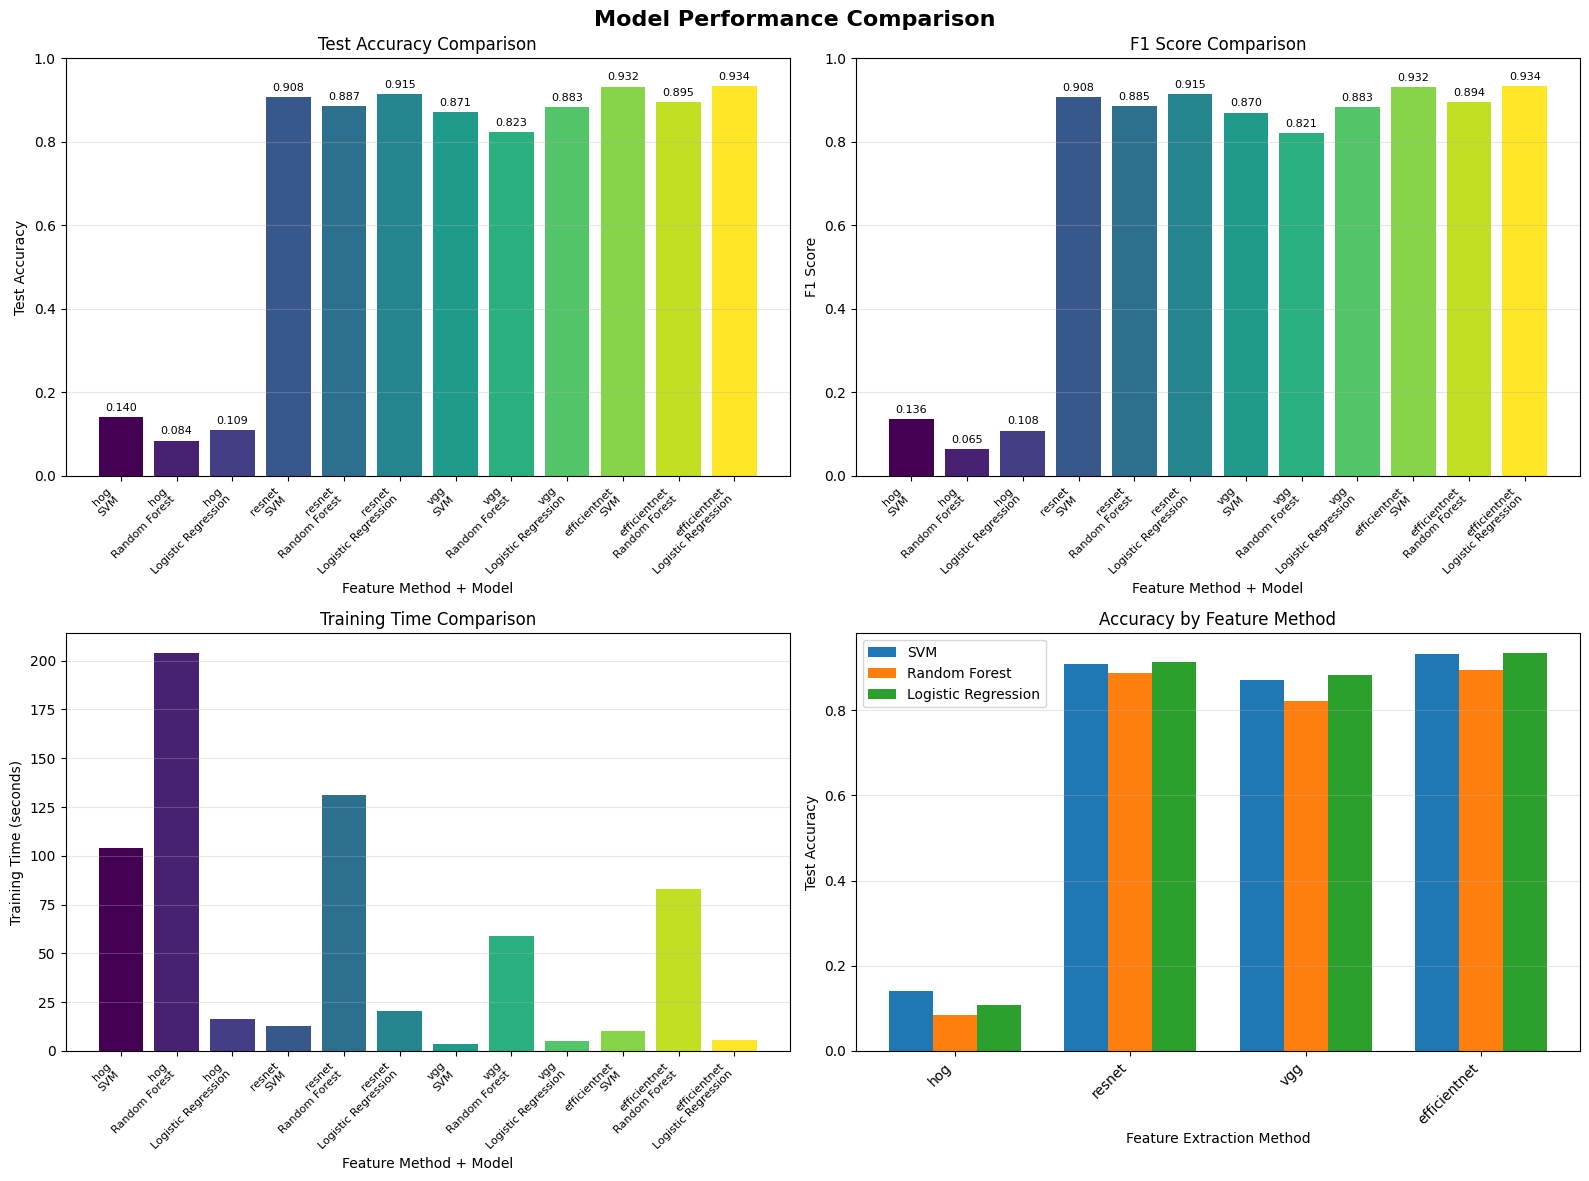

In [59]:
transforms_traditional = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ])


transforms_deep = transforms.Compose(transforms_traditional.transforms +
                                         [
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])
                                         ])

# Initialize pipeline

pipeline_traditional = DataProcessor(
    img_size=(224, 224),
    test_size=0.2,
    val_size=0.25,
    random_state=42,
    batch_size=48,
    num_workers=0,
    verbose=True,
    transform=transforms_traditional
)
pipeline_traditional.prepare(images_path, labels)

pipeline_deep = DataProcessor(
        test_size=0.2,
        val_size=0.25,
        random_state=42,
        batch_size=48,
        num_workers=0,
        verbose=True,
        transform=transforms_deep
    )

pipeline_deep.prepare(images_path, labels)

os.makedirs('../features', exist_ok=True)

feature_methods = ['hog', 'resnet', 'vgg', 'efficientnet']

# Initialize comparator
comparator = ModelComparator()

for method in feature_methods:
    feature_path = f'../features/{method}_features.npz'
    if os.path.exists(feature_path):
        print(f"Loading cached features for {method.upper()} from {feature_path}...")
        data = np.load(feature_path)
        X_train = data['X_train']
        X_val = data['X_val']
        X_test = data['X_test']
        y_train = data['y_train']
        y_val = data['y_val']
        y_test = data['y_test']
    else:
        print(f"Extracting features using {method.upper()}...")

        if method == 'hog':
            train_loader, val_loader, test_loader = pipeline_traditional.get_dataloaders()
        else:
            train_loader, val_loader, test_loader = pipeline_deep.get_dataloaders()
        device = 'cuda' if method in ['resnet', 'vgg', 'efficientnet'] else 'cpu'
        extractor = FeatureExtractor(method,device = device, verbose=True)
        X_train, X_val, X_test, y_train, y_val, y_test = extractor.extract(train_loader, val_loader, test_loader)

        if method =='hog':
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

            pca_reducer = PCAReducer(variance_ratio=0.95, verbose=True)

            X_train, X_val, X_test = pca_reducer.fit_transform(X_train, X_val, X_test)

        np.savez_compressed(feature_path,
                            X_train=X_train,
                            X_val=X_val,
                            X_test= X_test,
                            y_train=y_train,
                            y_val=y_val,
                            y_test=y_test
                            )


    # Initialize model trainer
    trainer = ModelTrainer(verbose=True)

    trainer.prepare_models()


    results = trainer.train_and_evaluate(
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        feature_name=method
    )
    comparator.add_results(method, results)

comparator.print_comparison()

best_feature, best_model, best_acc = comparator.find_best_model()

comparator.plot_comparison(save_path='model_comparison.png')